# Apply $\pi^+/\pi^-$ acceptance matching cut in $p-\theta$ plane and then acceptance correction in $\phi$

last edit Mar-10, 2022

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
from acceptance_correction_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
main_data_path     = '/Users/erezcohen/Desktop/data/BAND/'
e_e_pi_data_path   = main_data_path + 'SIDIS_skimming/'
e_e_pi_n_data_path = main_data_path + 'merged_SIDIS_and_BAND_skimming/'

## Auxiliary functions

In [55]:
phi_min   = -180 # deg.
phi_max   = 180  # deg.
phi_bins  = np.linspace(phi_min, phi_max,91)

In [135]:
def Find_phi_bin( phi ):
    # input phi in [deg.]
    # return phi bin index (/indices)
    idx_arr = np.digitize(phi,phi_bins)
    return idx_arr

In [136]:
def Compute_acceptance_correction_weight( pi_charge_name, phi ):
    phi_bin = Find_phi_bin( phi )
    acceptance_correction_weight = AccCorrec[pi_charge_name][phi_bin]
    acceptance_correction_weight_err = AccCorrec_err[pi_charge_name][phi_bin]
    return acceptance_correction_weight

# Load data from 101 runs of 10.2 GeV

In [3]:
runs_filename = "/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/macros/runlists/good_runs_10-2.txt"
Nruns = 1

In [4]:
# Using readlines()
runs_file     = open(runs_filename, 'r')
run_fileLines = runs_file.readlines()
runs = []
for line in run_fileLines[0:Nruns]:#{
    run = int(line.strip())
    runs.append(run)
runs = np.array(runs)

In [21]:
fdebug   = 2
e_e_pi   = dict()
for runnum,runIdx in zip(runs,range(len(runs))):
    for pi_charge_name in pi_charge_names:
        eepi   = pd.read_csv(e_e_pi_data_path 
                                           +'skimmed_SIDIS_inc_00%d_e_%s_selected_eepi_kinematics.csv'%(runnum,pi_charge_name))
        if fdebug>1: print('loaded',len(eepi),'(e,e',pi_charge_name,') events ')    
            
        if runIdx==0:             
            e_e_pi[pi_charge_name]   = eepi
        else:
            e_e_pi[pi_charge_name]   = pd.concat([e_e_pi[pi_charge_name],  eepi ])
    print('loaded file %d/%d files'%(runIdx,len(runs)))
    
print('done.')

loaded 644241 (e,e piplus ) events 
loaded 274002 (e,e piminus ) events 
loaded file 0/1 files
done.


# (1) Apply acceptance matching cut

In [22]:
pi_charge_names  = ['piplus'   ,'piminus'  ]
pi_labels        = ['\pi^{+}'  ,'\pi^{-}'  ]
pi_colors        = ['royalblue','black'   ]

In [23]:
Nevents = dict()
frac_Nevents = dict()
for pi_charge_name in pi_charge_names:
    Nevents[pi_charge_name + ' original'] = len(e_e_pi[pi_charge_name])
    frac_Nevents[pi_charge_name + ' original'] = 1
    print(Nevents[pi_charge_name + ' original'],'(e,e',pi_charge_name,') events before cut')    
    
e_e_pi = apply_p_theta_acceptance_cut(df_dict=e_e_pi)
print('done applying acceptance matching cut in p-theta plane')
for pi_charge_name in pi_charge_names:
    Nevents[pi_charge_name +' p-theta cut'] = len(e_e_pi[pi_charge_name])
    frac_Nevents[pi_charge_name + ' p-theta cut'] = (float(Nevents[pi_charge_name +' p-theta cut'])/
                                                  Nevents[pi_charge_name + ' original'])
    print(Nevents[pi_charge_name +' p-theta cut'],'(e,e',pi_charge_name,') events after cut')    

644241 (e,e piplus ) events before cut
274002 (e,e piminus ) events before cut
done applying acceptance matching cut in p-theta plane
441990 (e,e piplus ) events after cut
265536 (e,e piminus ) events after cut


In [24]:
for pi_charge_name in pi_charge_names:
    print(Nevents[pi_charge_name + ' original'],'(e,e',pi_charge_name,') events before cut')    
    print(Nevents[pi_charge_name +' p-theta cut'],'(e,e',pi_charge_name,') events after cut')    
    print(100.*frac_Nevents[pi_charge_name +' p-theta cut'],'% (e,e',pi_charge_name,') survive after cut')    

644241 (e,e piplus ) events before cut
441990 (e,e piplus ) events after cut
68.60631347585763 % (e,e piplus ) survive after cut
274002 (e,e piminus ) events before cut
265536 (e,e piminus ) events after cut
96.91024153108371 % (e,e piminus ) survive after cut


# (2) Plot acceptance as a function of $\phi$
(Compute and plot it)

For all simulated events

Important note: the acceptance correciton is computed in fixed bins of $\phi$

In [58]:
h, h_err = dict(),dict()
AccCorrec, AccCorrec_err = dict(),dict()

In [59]:
sim_data_path = '/Users/erezcohen/Desktop/data/BAND/AcceptanceCorrection/GEMCimulationOuputFiles/'
eepips_GEMC = pd.read_csv( sim_data_path + 'eepips_p_uniform_distribution.csv')
eepims_GEMC = pd.read_csv( sim_data_path + 'eepims_p_uniform_distribution.csv')

# Omit events in which the electron is not reconstructed
print('%d generated events'%len(eepips_GEMC))
eepips_GEMC = eepips_GEMC[eepips_GEMC.e_passed_cuts==1]
eepims_GEMC = eepims_GEMC[eepims_GEMC.e_passed_cuts==1]


for eepi_GEMC,pi_charge_name in zip([eepips_GEMC,eepims_GEMC],pi_charge_names):
    print(pi_charge_name)
    print('%d events in which electron was reconsutrcted'%len(eepi_GEMC[eepi_GEMC.e_passed_cuts==1]))
    Nevents = len(eepi_GEMC)
    print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_reconstructed==1]) /Nevents),'% (','%d events) include pi+ reconstructed'%len(eepi_GEMC[eepi_GEMC.pi_reconstructed==1]))
    print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_passed_fiducial_cuts==1]) /Nevents),'% (','%d events) include pi+ passed fiducial cuts'%len(eepi_GEMC[eepi_GEMC.pi_passed_fiducial_cuts==1]))
    print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_passed_PID_cuts==1]) /Nevents),'% (','%d events) include pi+ passed PID cuts'%len(eepi_GEMC[eepi_GEMC.pi_passed_PID_cuts==1]))
    print('%.1f'%(100.*len(eepi_GEMC[eepi_GEMC.pi_passed_cuts==1]) /Nevents),'% (','%d events) include pi+ passed all cuts'%len(eepi_GEMC[eepi_GEMC.pi_passed_cuts==1]))

100046 generated events
piplus
46266 events in which electron was reconsutrcted
65.5 % ( 30311 events) include pi+ reconstructed
64.3 % ( 29768 events) include pi+ passed fiducial cuts
63.8 % ( 29511 events) include pi+ passed PID cuts
62.7 % ( 29018 events) include pi+ passed all cuts
piminus
45858 events in which electron was reconsutrcted
61.7 % ( 28287 events) include pi+ reconstructed
60.4 % ( 27717 events) include pi+ passed fiducial cuts
60.1 % ( 27567 events) include pi+ passed PID cuts
58.9 % ( 27033 events) include pi+ passed all cuts


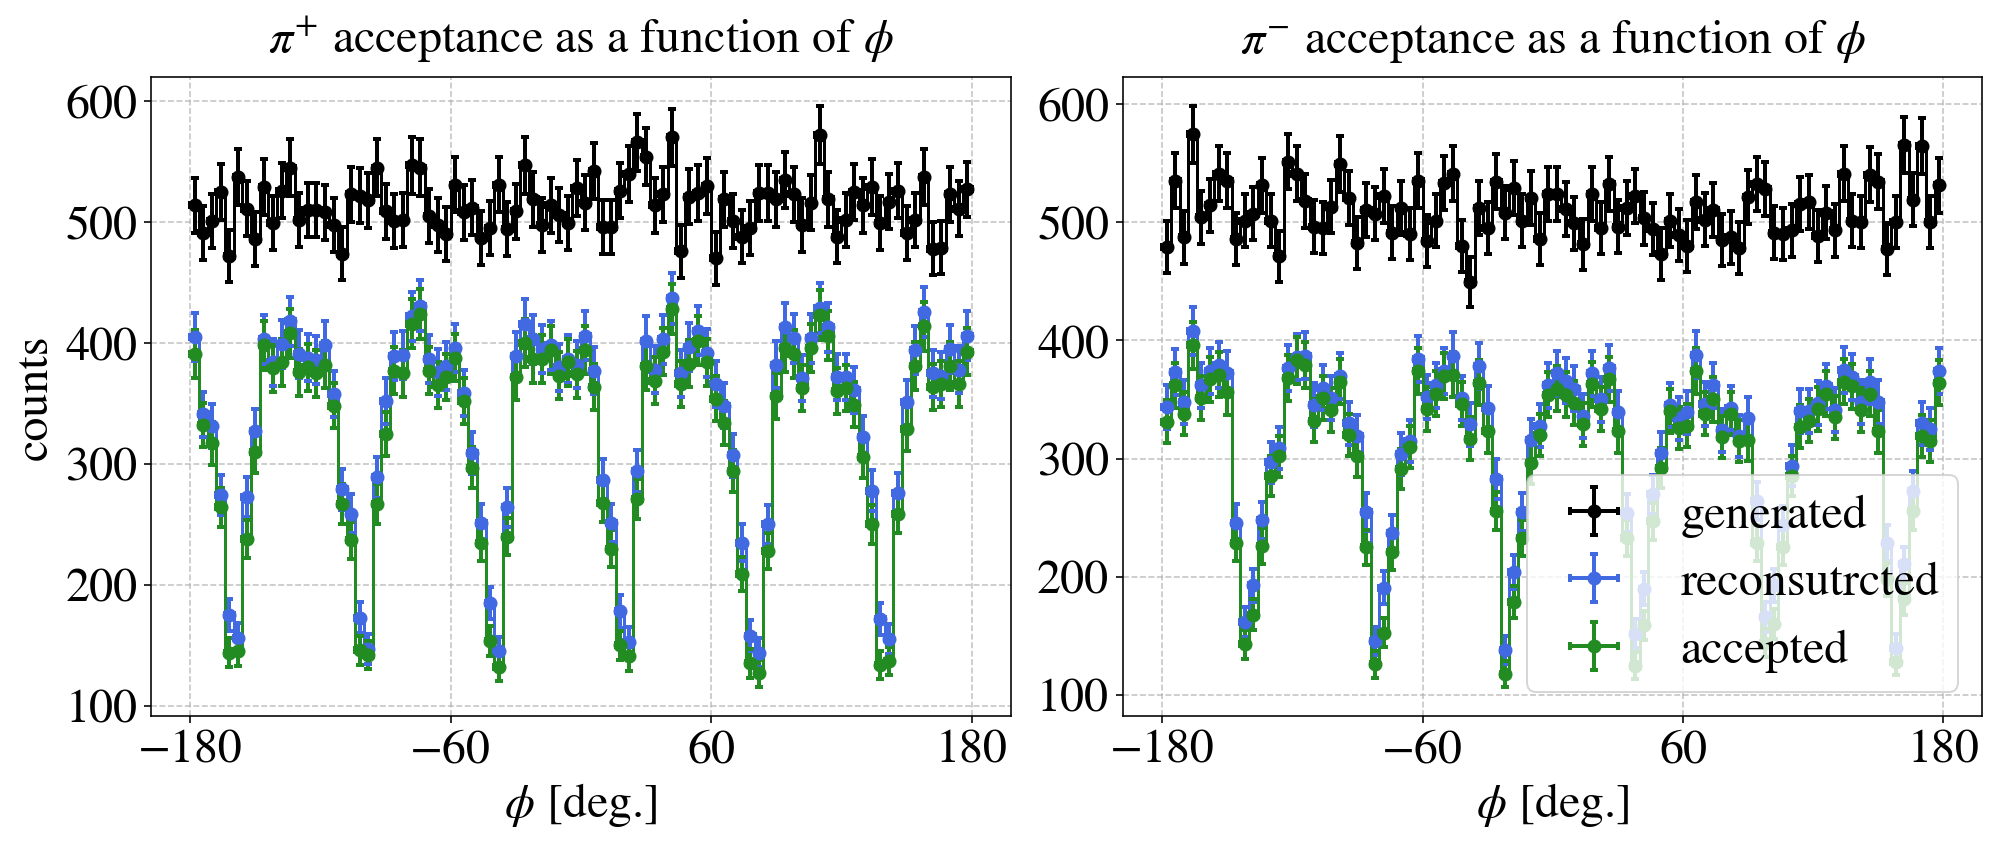

In [60]:
var_gen      = 'pi_Phi_g'
label        = '$\phi$'
units        = '[deg.]'
scale_factor = r2d
xticks       = [-180,-60,60,180]


fig = plt.figure(figsize=(14,6));
for eepi_GEMC,pi_charge_name,pi_charge_label,pi_idx in zip([eepips_GEMC,eepims_GEMC],pi_charge_names,pi_labels,range(2)):
    pi_ch = pi_charge_name
    df_gen = eepi_GEMC;
    df_rec = eepi_GEMC[eepi_GEMC.pi_reconstructed==1];
    df_acc = eepi_GEMC[eepi_GEMC.pi_passed_cuts  ==1];    
    x_gen = df_gen[var_gen]
    x_rec = df_rec[var_gen]    
    x_acc = df_acc[var_gen]    


    ax = fig.add_subplot(1,2,pi_idx+1)
    x,h[pi_ch+'gen'],x_err,h_err[pi_ch+'gen'] = plot_step_hist( x_gen*scale_factor, phi_bins, color='k',           label='generated')
    x,h[pi_ch+'rec'],x_err,h_err[pi_ch+'rec'] = plot_step_hist( x_rec*scale_factor, phi_bins, color='royalblue',   label='reconsutrcted')
    x,h[pi_ch+'acc'],x_err,h_err[pi_ch+'acc'] = plot_step_hist( x_acc*scale_factor, phi_bins, color='forestgreen', label='accepted')            

    # ax.set_yscale('log')
    set_axes(ax,label + ' ' + units,'counts' if pi_idx==0 else '',
                do_add_legend=True if pi_idx==1 else False,
                 title='$'+pi_charge_label+'$ acceptance as a function of '+label, fontsize=24, do_add_grid=True,xticks=xticks)
    
plt.tight_layout();

In [64]:
for eepi_GEMC,pi_charge_name,pi_charge_label,pi_idx in zip([eepips_GEMC,eepims_GEMC],pi_charge_names,pi_labels,range(2)):
    pi_ch = pi_charge_name
    h[pi_ch+'eff'] = h[pi_ch+'acc']/h[pi_ch+'gen']
    h_err[pi_ch+'eff'] = h[pi_ch+'eff']*np.sqrt( np.square(h_err[pi_ch+'acc']/h[pi_ch+'acc']) + np.square(h_err[pi_ch+'gen']/h[pi_ch+'gen'])  )


    AccCorrec[pi_ch]     = 1./h[pi_ch+'eff']
    AccCorrec_err[pi_ch] = h_err[pi_ch+'eff']/np.square( h[pi_ch+'eff'] )

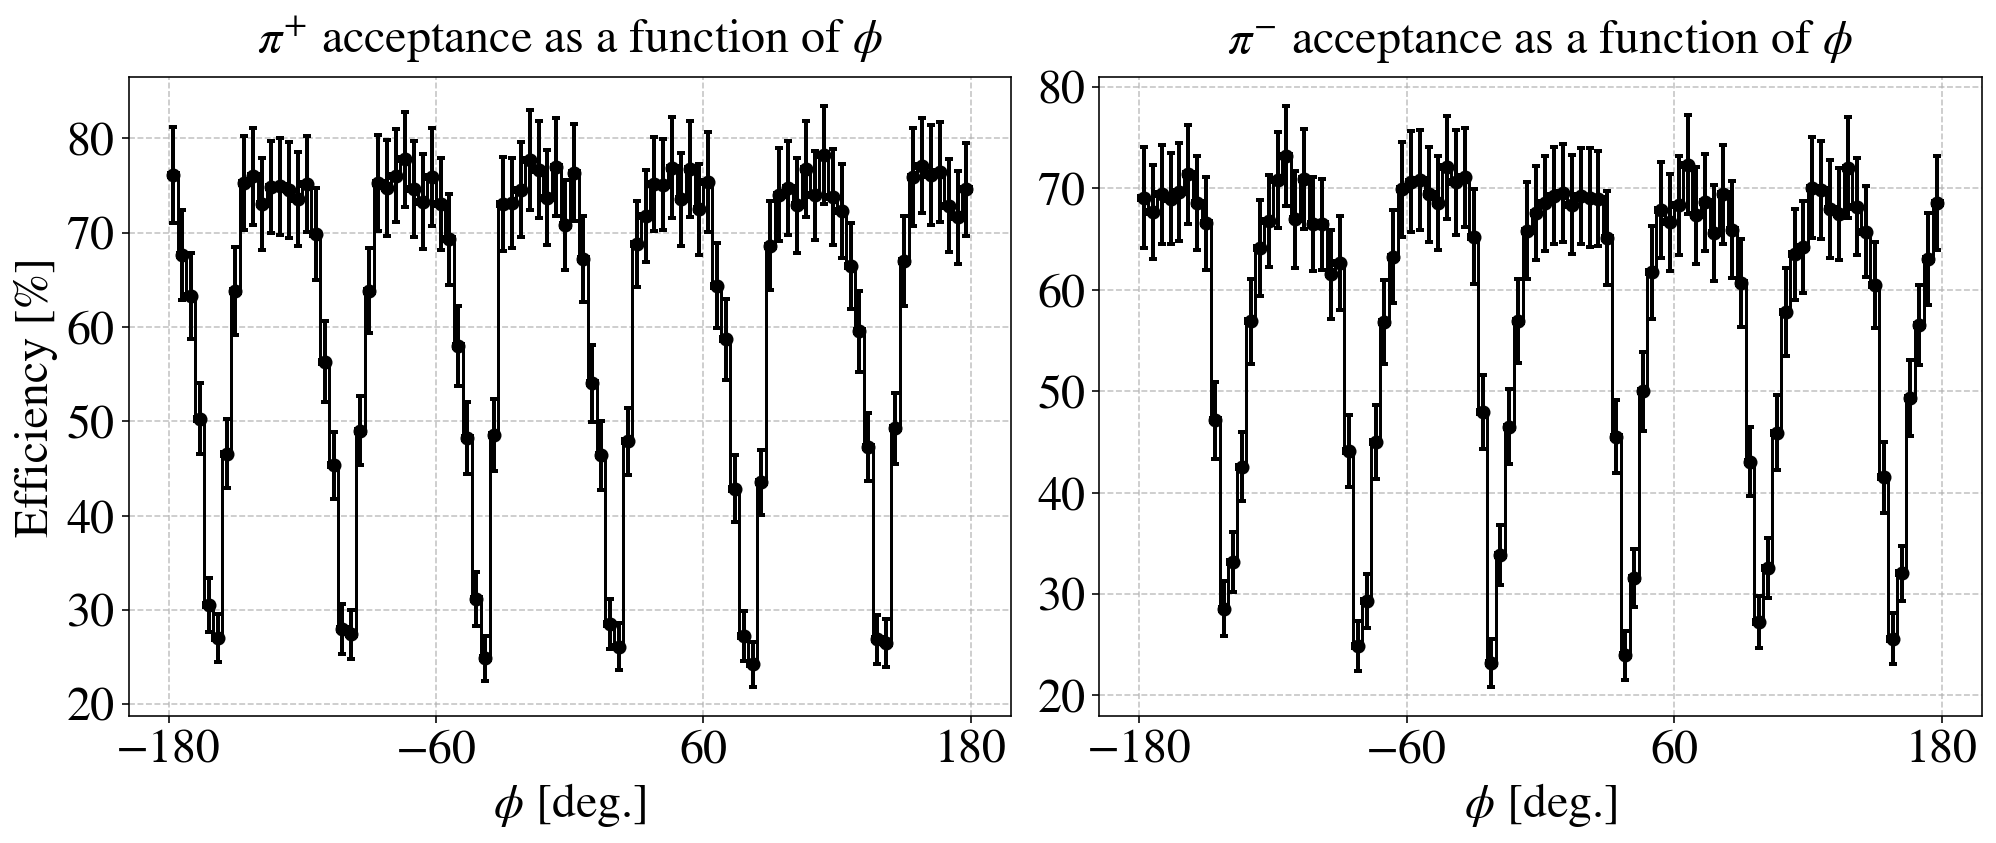

In [157]:
color = 'k'
capsize=2
capthick=2
marker='o'
linewidth=2
    
fig = plt.figure(figsize=(14,6));
for eepi_GEMC,pi_charge_name,pi_charge_label,pi_idx in zip([eepips_GEMC,eepims_GEMC],pi_charge_names,pi_labels,range(2)):
    pi_ch = pi_charge_name
    ax = fig.add_subplot(1,2,pi_idx+1)
    plt.step ( x, h[pi_ch+'eff']*100., color=color, where='mid', label=None )
    plt.errorbar ( x=x, xerr=x_err, y=h[pi_ch+'eff']*100., yerr=h_err[pi_ch+'eff']*100.,
                  color=color, marker='o', linestyle='None',label=label,
                  capsize=capsize, capthick=capthick, linewidth=linewidth )
    
    set_axes(ax,label + ' ' + units,'Efficiency [%]' if pi_idx==0 else '',
        do_add_legend=False,
        title='$'+pi_charge_label+'$ acceptance as a function of '+label, fontsize=24, do_add_grid=True,xticks=xticks)

plt.tight_layout();

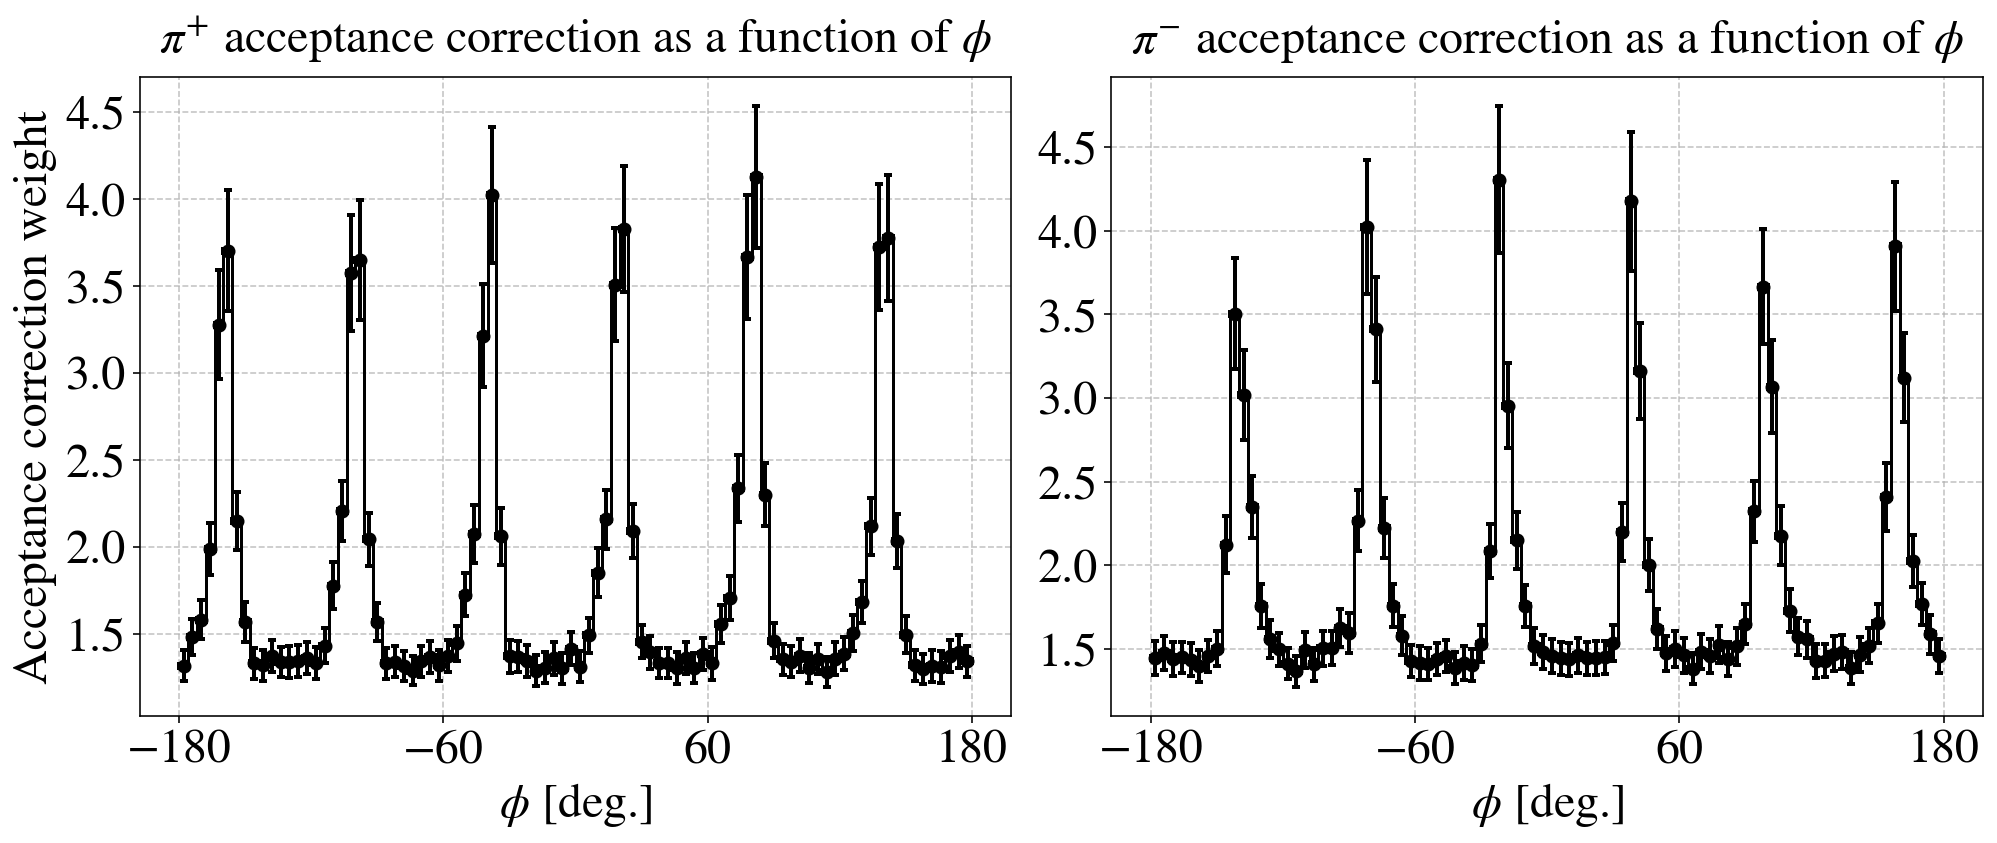

In [161]:
   
fig = plt.figure(figsize=(14,6));
for eepi_GEMC,pi_charge_name,pi_charge_label,pi_idx in zip([eepips_GEMC,eepims_GEMC],pi_charge_names,pi_labels,range(2)):
    pi_ch = pi_charge_name
    ax = fig.add_subplot(1,2,pi_idx+1)
    plt.step ( x, AccCorrec[pi_ch], color=color, where='mid', label=None )
    plt.errorbar ( x=x, xerr=x_err, y=AccCorrec[pi_ch], yerr=AccCorrec_err[pi_ch],
                  color=color, marker='o', linestyle='None',label=label,
                  capsize=capsize, capthick=capthick, linewidth=linewidth )
    
    set_axes(ax,label + ' ' + units,'Acceptance correction weight' if pi_idx==0 else '',
        do_add_legend=False,
        title='$'+pi_charge_label+'$ acceptance correction as a function of '+label, fontsize=24, do_add_grid=True,xticks=xticks)
    
plt.tight_layout();

# (3) Check the acceptance correction
To check the correction, plot the data as a function of $\phi$, where each event is weighted by its own correction factor

### Compute correction for a single event as example

In [137]:
event = e_e_pi[pi_charge_name].iloc[1]
phi = float(event.pi_Phi)*r2d
print('event phi: ',phi ,'deg.')

phi_bin = Find_phi_bin( phi )
print('phi bin: ',phi_bin)

W_acc_corr = Compute_acceptance_correction_weight( pi_charge_name, phi )
print('W_acc_corr:',W_acc_corr)

event phi:  3.5640725054553832 deg.
phi bin:  46
W_acc_corr: 1.4435028248587571


### Compute correction for all events

In [153]:
for pi_charge_name,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
    # print(pi_charge_name)
    df = e_e_pi_after_cut[pi_charge_name];
    phis = np.array( df.pi_Phi )
    acc_corr_weights = [ Compute_acceptance_correction_weight( pi_charge_name, phi ) for phi in phis ]
    df = df.assign(Weight_AccCorrec = acc_corr_weights)
    e_e_pi_after_cut[pi_charge_name] = df
    # display(df)
    print('Computing acceptance correction weights for ',pi_charge_name,'.')
#}
print('Done computing acceptance correction weights.')

Computing acceptance correction weights for  piplus .
Computing acceptance correction weights for  piminus .
Done computing acceptance correction weights.


### Plot $\phi$ distribution with and without application of the acceptance correction weights

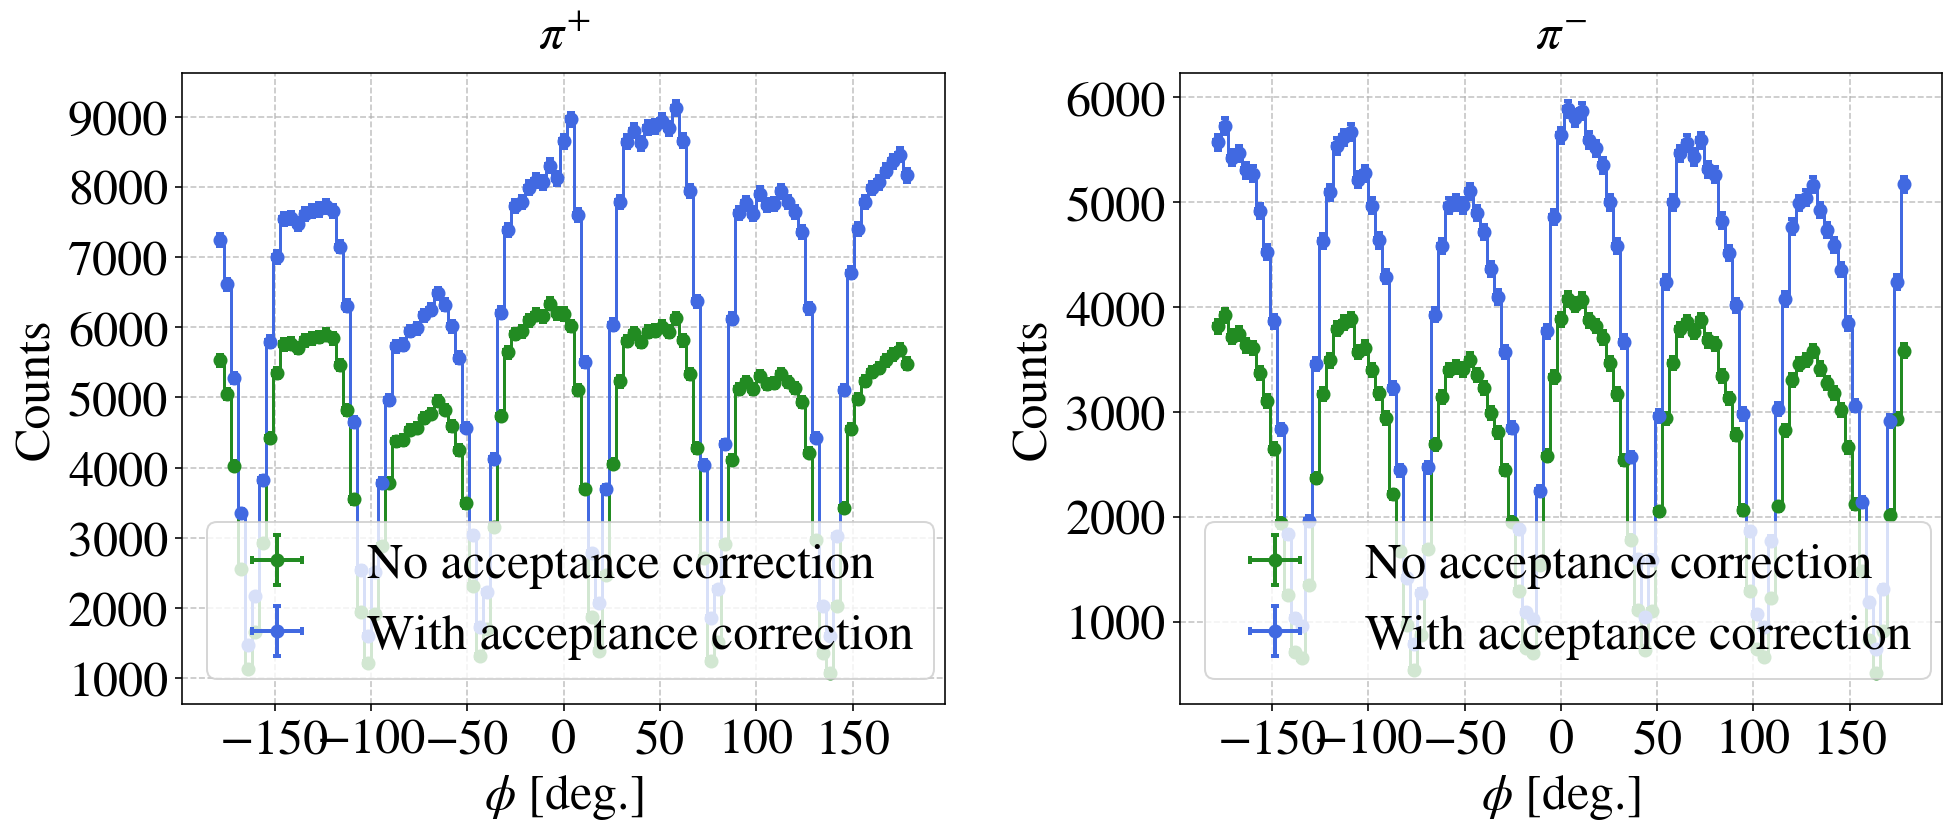

In [156]:
bins=np.linspace(-180,180,100)

fig = plt.figure(figsize=(14,6));

for pi_charge_name,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):#{
    df = e_e_pi[pi_charge_name];
    phi = np.array(e_e_pi[pi_charge_name].pi_Phi)*r2d
    
    
    ax = fig.add_subplot(1,2,pi_idx)
    
    plot_step_hist( x_arr=np.array(e_e_pi_after_cut[pi_charge_name].pi_Phi)*r2d, 
                   bins=bins , label='No acceptance correction', 
                   color='forestgreen' )

    plot_step_hist( x_arr=np.array(e_e_pi_after_cut[pi_charge_name].pi_Phi)*r2d,                    
                   bins=bins , label='With acceptance correction', 
                   weights=np.array(e_e_pi_after_cut[pi_charge_name].Weight_AccCorrec),
                   color='royalblue' )

    set_axes(ax, '$\phi$ [deg.]', 'Counts', title='$'+pi_label+'$', do_add_grid=True,do_add_legend=True)
    
plt.tight_layout()